# Solving a QUBO using VQE in qiskit

In [1]:
import sys
sys.path.append('../')
from src.sharedstate import SharedState
from src.qubo import Qubo

In [2]:
# SharedState does all the file loading
ss = SharedState()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from SharedState.
q = Qubo(ss)

In [3]:
import numpy as np

from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE

from qiskit import transpile 
from qiskit import Aer

We pick a qubo matrix and apply VQE to solve it using a few different optimizers.

In [78]:
qubo, ising_ham = q.qubo_hamiltonian_pairs[0] # use the first slice as an example to solve

# number of qubits for the ansatz is equal to the size of the qubo matrix
num_qubits = len(qubo)

# optimizers to be used
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

In [79]:
from qiskit_algorithms.utils import algorithm_globals

estimator = Estimator()
backend = Aer.get_backend('aer_simulator')

vqe_results = []


for i, optimizer in enumerate(optimizers):
    # define the ansatz to be used in vqe
    ansatz = TwoLocal(num_qubits, 'ry', 'cz',  entanglement='linear', reps=1)

    counts = []
    values = []

    # for reproducable results
    algorithm_globals.random_seed = 3       

    # a callback function for the vqe
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    # intialize vqe instance
    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)

    result = vqe.compute_minimum_eigenvalue(operator=ising_ham)
    vqe_results.append(result)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
  
    opt_params = result.optimal_point
    qc = ansatz.assign_parameters(opt_params)

    
    # First we have to transpile the quantum circuit 
    # to the low-level QASM instructions used by the 
    # backend
    qc_compiled = transpile(qc, backend)
    qc_compiled.measure_active()

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = backend.run(qc_compiled, shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()
    msrmnts = result_sim.get_counts()

    # since bits are flipped, the solution is
    sol = q.get_most_likely(msrmnts=msrmnts)
    energy = q.ising_energy(assignment=sol, qubo=qubo)

    print(f"solution {sol} with energy {energy:.5f}")


solution [0, 0, 0, 1] with energy -0.00969
solution [0, 0, 0, 1] with energy -0.00969
solution [0, 0, 0, 1] with energy -0.00969


The ansatz circuit. It consists of 16 single qubit gates (which is also equal to the number of parameters) and 3 layers of full entanglement blocks.

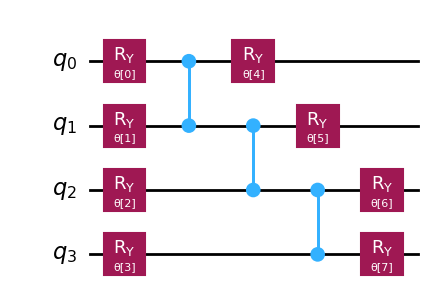

In [80]:
ansatz.decompose().draw('mpl', style='iqx')

In [81]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

([1, 0, 0, 0], -0.010743767178636635)

In the following, we plot the convergence of the energy in each VQE step for each optimizer. The y-axis is the absolute value of the difference between the VQE and the true minimum energy. The x-axis is the number of evaluations of the circuit.

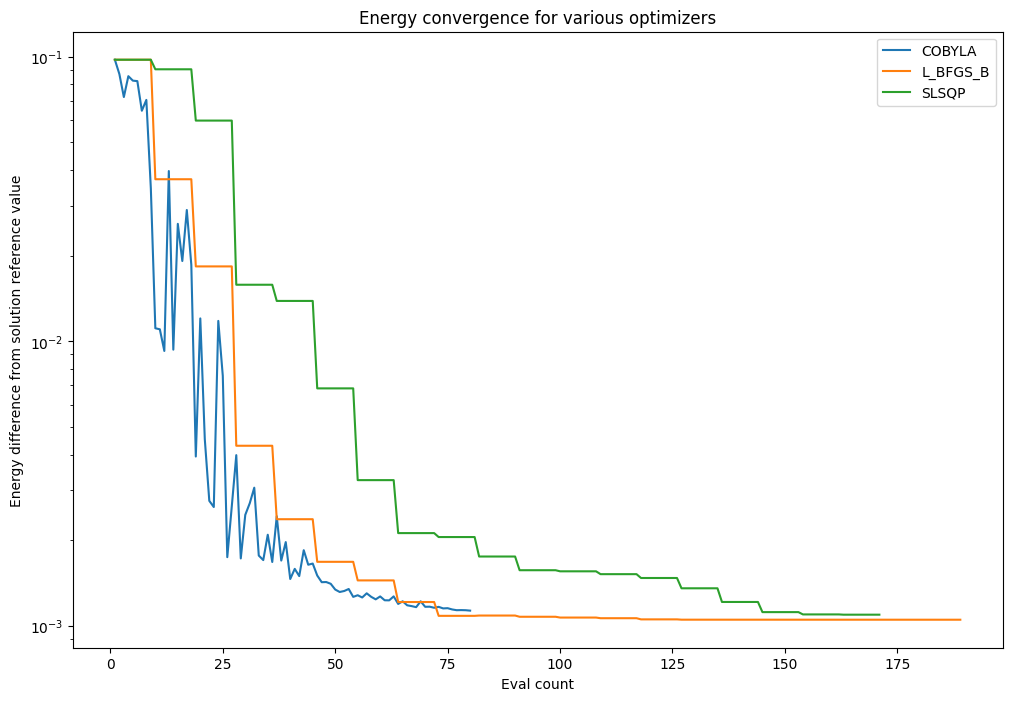

In [82]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
#pylab.plot(range(1200), [10**(-3)]*1200, label="error threshold")
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

## Resource estimation

In [83]:
num_single_qubit_gates = ansatz.num_parameters
num_cz_gates = ansatz.num_qubits - 1
optimizer_names = ["COBYLA", "L_BFGS_B", "SLSQP"]

for i, optimizer in enumerate(optimizers):
    print(f"{optimizer_names[i]}: controlled-Z gates {num_cz_gates*vqe_results[i].cost_function_evals}")
    print(f"single-qubit rotation gates {num_single_qubit_gates*vqe_results[i].cost_function_evals}")
    print(f"error: {np.abs(ref_value-vqe_results[i].eigenvalue)}")
    print("")

COBYLA: controlled-Z gates 240
single-qubit rotation gates 640
error: 0.001132060030951709

L_BFGS_B: controlled-Z gates 567
single-qubit rotation gates 1512
error: 0.0010517300029243646

SLSQP: controlled-Z gates 513
single-qubit rotation gates 1368
error: 0.0010955063782494417

